In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_1:cores",
    "device": "cuda",
    "lr": 0.0001,
    "labels": [
        "1-10.",
        "1-11.",
        "1-15.",
        "1-16.",
        "1-17.",
        "1-18.",
        "1-19.",
        "10-4.",
        "10-7.",
        "11-1.",
        "11-14.",
        "11-17.",
        "11-20.",
        "11-7.",
        "13-20.",
        "13-8.",
        "14-10.",
        "14-11.",
        "14-14.",
        "14-7.",
        "15-1.",
        "15-20.",
        "16-1.",
        "16-16.",
        "17-10.",
        "17-11.",
        "17-2.",
        "19-1.",
        "19-16.",
        "19-19.",
        "19-20.",
        "19-3.",
        "2-10.",
        "2-11.",
        "2-17.",
        "2-18.",
        "2-20.",
        "2-3.",
        "2-4.",
        "2-5.",
        "2-6.",
        "2-7.",
        "2-8.",
        "3-13.",
        "3-18.",
        "3-3.",
        "4-1.",
        "4-10.",
        "4-11.",
        "4-19.",
        "5-5.",
        "6-15.",
        "7-10.",
        "7-14.",
        "8-18.",
        "8-20.",
        "8-3.",
        "8-8.",
    ],
    "batch_size": 128,
    "domains_source": [1, 5],
    "domains_target": [2, 3, 4],
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 58}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name_source": "cores.stratified_ds.2022A.pkl",
    "pickle_name_target": "cores.stratified_ds.2022A.pkl",
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 568], examples_per_second: 741.5518, train_label_loss: 3.9343, 


epoch: 1, [batch: 57 / 568], examples_per_second: 10622.0814, train_label_loss: 2.7613, 


epoch: 1, [batch: 114 / 568], examples_per_second: 10583.5995, train_label_loss: 1.9293, 


epoch: 1, [batch: 171 / 568], examples_per_second: 10721.0019, train_label_loss: 1.4066, 


epoch: 1, [batch: 227 / 568], examples_per_second: 10771.0238, train_label_loss: 1.0740, 


epoch: 1, [batch: 284 / 568], examples_per_second: 10758.0889, train_label_loss: 0.6326, 


epoch: 1, [batch: 341 / 568], examples_per_second: 10834.3687, train_label_loss: 0.5001, 


epoch: 1, [batch: 397 / 568], examples_per_second: 10684.9931, train_label_loss: 0.3478, 


epoch: 1, [batch: 454 / 568], examples_per_second: 10735.2147, train_label_loss: 0.2938, 


epoch: 1, [batch: 511 / 568], examples_per_second: 10676.3085, train_label_loss: 0.2894, 


epoch: 1, source_val_acc_label: 0.9808, source_val_label_loss: 0.1805, target_val_acc_label: 0.8303, target_val_label_loss: 0.7063, 


New best
epoch: 2, [batch: 1 / 568], examples_per_second: 98.7447, train_label_loss: 0.1907, 


epoch: 2, [batch: 57 / 568], examples_per_second: 10217.9105, train_label_loss: 0.1631, 


epoch: 2, [batch: 114 / 568], examples_per_second: 10519.5202, train_label_loss: 0.1469, 


epoch: 2, [batch: 171 / 568], examples_per_second: 10663.5033, train_label_loss: 0.1054, 


epoch: 2, [batch: 227 / 568], examples_per_second: 10732.9487, train_label_loss: 0.0960, 


epoch: 2, [batch: 284 / 568], examples_per_second: 10650.5286, train_label_loss: 0.0801, 


epoch: 2, [batch: 341 / 568], examples_per_second: 10676.5469, train_label_loss: 0.0736, 


epoch: 2, [batch: 397 / 568], examples_per_second: 10480.4306, train_label_loss: 0.0729, 


epoch: 2, [batch: 454 / 568], examples_per_second: 10655.3570, train_label_loss: 0.0687, 


epoch: 2, [batch: 511 / 568], examples_per_second: 10532.8300, train_label_loss: 0.0747, 


epoch: 2, source_val_acc_label: 0.9939, source_val_label_loss: 0.0610, target_val_acc_label: 0.8512, target_val_label_loss: 0.5659, 


New best
epoch: 3, [batch: 1 / 568], examples_per_second: 116.0074, train_label_loss: 0.0601, 


epoch: 3, [batch: 57 / 568], examples_per_second: 10555.4165, train_label_loss: 0.0859, 


epoch: 3, [batch: 114 / 568], examples_per_second: 10661.1443, train_label_loss: 0.0432, 


epoch: 3, [batch: 171 / 568], examples_per_second: 10691.2209, train_label_loss: 0.0301, 


epoch: 3, [batch: 227 / 568], examples_per_second: 10632.5208, train_label_loss: 0.0329, 


epoch: 3, [batch: 284 / 568], examples_per_second: 10511.3829, train_label_loss: 0.0246, 


epoch: 3, [batch: 341 / 568], examples_per_second: 10659.5920, train_label_loss: 0.0241, 


epoch: 3, [batch: 397 / 568], examples_per_second: 10744.6363, train_label_loss: 0.0332, 


epoch: 3, [batch: 454 / 568], examples_per_second: 10731.0587, train_label_loss: 0.0388, 


epoch: 3, [batch: 511 / 568], examples_per_second: 10684.4832, train_label_loss: 0.0408, 


epoch: 3, source_val_acc_label: 0.9868, source_val_label_loss: 0.0834, target_val_acc_label: 0.8448, target_val_label_loss: 0.6509, 


epoch: 4, [batch: 1 / 568], examples_per_second: 125.1560, train_label_loss: 0.1137, 


epoch: 4, [batch: 57 / 568], examples_per_second: 10742.6975, train_label_loss: 0.0954, 


epoch: 4, [batch: 114 / 568], examples_per_second: 10617.8169, train_label_loss: 0.0877, 


epoch: 4, [batch: 171 / 568], examples_per_second: 10772.1613, train_label_loss: 0.0352, 


epoch: 4, [batch: 227 / 568], examples_per_second: 10488.5182, train_label_loss: 0.0904, 


epoch: 4, [batch: 284 / 568], examples_per_second: 10654.1922, train_label_loss: 0.0248, 


epoch: 4, [batch: 341 / 568], examples_per_second: 10584.1523, train_label_loss: 0.0353, 


epoch: 4, [batch: 397 / 568], examples_per_second: 10614.5810, train_label_loss: 0.0175, 


epoch: 4, [batch: 454 / 568], examples_per_second: 10511.6176, train_label_loss: 0.0171, 


epoch: 4, [batch: 511 / 568], examples_per_second: 10678.3203, train_label_loss: 0.0135, 


epoch: 4, source_val_acc_label: 0.9908, source_val_label_loss: 0.0476, target_val_acc_label: 0.8480, target_val_label_loss: 0.6657, 


epoch: 5, [batch: 1 / 568], examples_per_second: 120.6302, train_label_loss: 0.0268, 


epoch: 5, [batch: 57 / 568], examples_per_second: 10706.8731, train_label_loss: 0.0576, 


epoch: 5, [batch: 114 / 568], examples_per_second: 10664.9787, train_label_loss: 0.0329, 


epoch: 5, [batch: 171 / 568], examples_per_second: 10759.4468, train_label_loss: 0.0316, 


epoch: 5, [batch: 227 / 568], examples_per_second: 10754.9565, train_label_loss: 0.0184, 


epoch: 5, [batch: 284 / 568], examples_per_second: 10742.9744, train_label_loss: 0.0308, 


epoch: 5, [batch: 341 / 568], examples_per_second: 10731.7135, train_label_loss: 0.0280, 


epoch: 5, [batch: 397 / 568], examples_per_second: 10692.8329, train_label_loss: 0.0328, 


epoch: 5, [batch: 454 / 568], examples_per_second: 10688.5061, train_label_loss: 0.0298, 


epoch: 5, [batch: 511 / 568], examples_per_second: 10704.7743, train_label_loss: 0.0151, 


epoch: 5, source_val_acc_label: 0.9930, source_val_label_loss: 0.0351, target_val_acc_label: 0.8517, target_val_label_loss: 0.5558, 


New best
epoch: 6, [batch: 1 / 568], examples_per_second: 123.6073, train_label_loss: 0.0188, 


epoch: 6, [batch: 57 / 568], examples_per_second: 10481.1248, train_label_loss: 0.0108, 


epoch: 6, [batch: 114 / 568], examples_per_second: 10740.7573, train_label_loss: 0.0115, 


epoch: 6, [batch: 171 / 568], examples_per_second: 10575.1692, train_label_loss: 0.0086, 


epoch: 6, [batch: 227 / 568], examples_per_second: 10647.7377, train_label_loss: 0.0075, 


epoch: 6, [batch: 284 / 568], examples_per_second: 10690.4142, train_label_loss: 0.0730, 


epoch: 6, [batch: 341 / 568], examples_per_second: 10717.5363, train_label_loss: 0.0109, 


epoch: 6, [batch: 397 / 568], examples_per_second: 10836.6002, train_label_loss: 0.0054, 


epoch: 6, [batch: 454 / 568], examples_per_second: 10601.3894, train_label_loss: 0.0043, 


epoch: 6, [batch: 511 / 568], examples_per_second: 10647.9790, train_label_loss: 0.0152, 


epoch: 6, source_val_acc_label: 0.9805, source_val_label_loss: 0.0848, target_val_acc_label: 0.8422, target_val_label_loss: 0.6557, 


epoch: 7, [batch: 1 / 568], examples_per_second: 123.5073, train_label_loss: 0.1192, 


epoch: 7, [batch: 57 / 568], examples_per_second: 10433.8383, train_label_loss: 0.0527, 


epoch: 7, [batch: 114 / 568], examples_per_second: 10776.2809, train_label_loss: 0.0092, 


epoch: 7, [batch: 171 / 568], examples_per_second: 10866.4391, train_label_loss: 0.0092, 


epoch: 7, [batch: 227 / 568], examples_per_second: 10758.2354, train_label_loss: 0.0154, 


epoch: 7, [batch: 284 / 568], examples_per_second: 10779.8265, train_label_loss: 0.0080, 


epoch: 7, [batch: 341 / 568], examples_per_second: 10801.0116, train_label_loss: 0.0074, 


epoch: 7, [batch: 397 / 568], examples_per_second: 10743.6688, train_label_loss: 0.0034, 


epoch: 7, [batch: 454 / 568], examples_per_second: 10607.3792, train_label_loss: 0.0073, 


epoch: 7, [batch: 511 / 568], examples_per_second: 10614.0090, train_label_loss: 0.0091, 


epoch: 7, source_val_acc_label: 0.9964, source_val_label_loss: 0.0168, target_val_acc_label: 0.8584, target_val_label_loss: 0.5754, 


New best
epoch: 8, [batch: 1 / 568], examples_per_second: 120.6495, train_label_loss: 0.0058, 


epoch: 8, [batch: 57 / 568], examples_per_second: 10612.5165, train_label_loss: 0.0070, 


epoch: 8, [batch: 114 / 568], examples_per_second: 10758.0132, train_label_loss: 0.0087, 


epoch: 8, [batch: 171 / 568], examples_per_second: 10591.6804, train_label_loss: 0.0057, 


epoch: 8, [batch: 227 / 568], examples_per_second: 10659.3461, train_label_loss: 0.0045, 


epoch: 8, [batch: 284 / 568], examples_per_second: 10702.3221, train_label_loss: 0.0030, 


epoch: 8, [batch: 341 / 568], examples_per_second: 10692.7339, train_label_loss: 0.0033, 


epoch: 8, [batch: 397 / 568], examples_per_second: 10864.2702, train_label_loss: 0.0079, 


epoch: 8, [batch: 454 / 568], examples_per_second: 11933.3492, train_label_loss: 0.0025, 


epoch: 8, [batch: 511 / 568], examples_per_second: 11686.4570, train_label_loss: 0.0031, 


epoch: 8, source_val_acc_label: 0.9972, source_val_label_loss: 0.0141, target_val_acc_label: 0.8598, target_val_label_loss: 0.5474, 


New best
epoch: 9, [batch: 1 / 568], examples_per_second: 134.0164, train_label_loss: 0.0041, 


epoch: 9, [batch: 57 / 568], examples_per_second: 11697.1620, train_label_loss: 0.0066, 


epoch: 9, [batch: 114 / 568], examples_per_second: 11662.6823, train_label_loss: 0.0031, 


epoch: 9, [batch: 171 / 568], examples_per_second: 11764.3150, train_label_loss: 0.0126, 


epoch: 9, [batch: 227 / 568], examples_per_second: 11916.6801, train_label_loss: 0.0288, 


epoch: 9, [batch: 284 / 568], examples_per_second: 11714.1077, train_label_loss: 0.0030, 


epoch: 9, [batch: 341 / 568], examples_per_second: 11717.4178, train_label_loss: 0.0131, 


epoch: 9, [batch: 397 / 568], examples_per_second: 11797.4994, train_label_loss: 0.0057, 


epoch: 9, [batch: 454 / 568], examples_per_second: 11791.5088, train_label_loss: 0.0092, 


epoch: 9, [batch: 511 / 568], examples_per_second: 11681.7059, train_label_loss: 0.0048, 


epoch: 9, source_val_acc_label: 0.9389, source_val_label_loss: 0.1996, target_val_acc_label: 0.8178, target_val_label_loss: 0.8787, 


epoch: 10, [batch: 1 / 568], examples_per_second: 136.8182, train_label_loss: 0.1548, 


epoch: 10, [batch: 57 / 568], examples_per_second: 11529.3530, train_label_loss: 0.0755, 


epoch: 10, [batch: 114 / 568], examples_per_second: 11656.6360, train_label_loss: 0.0197, 


epoch: 10, [batch: 171 / 568], examples_per_second: 11774.0693, train_label_loss: 0.0362, 


epoch: 10, [batch: 227 / 568], examples_per_second: 11933.2776, train_label_loss: 0.0297, 


epoch: 10, [batch: 284 / 568], examples_per_second: 12369.3525, train_label_loss: 0.0221, 


epoch: 10, [batch: 341 / 568], examples_per_second: 11669.8339, train_label_loss: 0.0053, 


epoch: 10, [batch: 397 / 568], examples_per_second: 13042.0229, train_label_loss: 0.0074, 


epoch: 10, [batch: 454 / 568], examples_per_second: 12949.8255, train_label_loss: 0.0052, 


epoch: 10, [batch: 511 / 568], examples_per_second: 13093.1575, train_label_loss: 0.0037, 


epoch: 10, source_val_acc_label: 0.9832, source_val_label_loss: 0.0578, target_val_acc_label: 0.8377, target_val_label_loss: 0.7034, 


epoch: 11, [batch: 1 / 568], examples_per_second: 154.9161, train_label_loss: 0.0730, 


epoch: 11, [batch: 57 / 568], examples_per_second: 12436.5020, train_label_loss: 0.0750, 


epoch: 11, [batch: 114 / 568], examples_per_second: 13064.4487, train_label_loss: 0.0220, 


epoch: 11, [batch: 171 / 568], examples_per_second: 12999.5387, train_label_loss: 0.0082, 


epoch: 11, [batch: 227 / 568], examples_per_second: 13088.5181, train_label_loss: 0.0149, 


epoch: 11, [batch: 284 / 568], examples_per_second: 13108.9237, train_label_loss: 0.0188, 


epoch: 11, [batch: 341 / 568], examples_per_second: 12987.4894, train_label_loss: 0.0078, 


epoch: 11, [batch: 397 / 568], examples_per_second: 12989.6579, train_label_loss: 0.0054, 


epoch: 11, [batch: 454 / 568], examples_per_second: 12935.5001, train_label_loss: 0.0041, 


epoch: 11, [batch: 511 / 568], examples_per_second: 12908.4632, train_label_loss: 0.0161, 


epoch: 11, source_val_acc_label: 0.9962, source_val_label_loss: 0.0185, target_val_acc_label: 0.8555, target_val_label_loss: 0.6308, 


epoch: 12, [batch: 1 / 568], examples_per_second: 154.1927, train_label_loss: 0.0028, 


epoch: 12, [batch: 57 / 568], examples_per_second: 12662.5724, train_label_loss: 0.0117, 


epoch: 12, [batch: 114 / 568], examples_per_second: 13004.6045, train_label_loss: 0.0064, 


epoch: 12, [batch: 171 / 568], examples_per_second: 13081.0068, train_label_loss: 0.0068, 


epoch: 12, [batch: 227 / 568], examples_per_second: 13451.5163, train_label_loss: 0.0077, 


epoch: 12, [batch: 284 / 568], examples_per_second: 13889.8548, train_label_loss: 0.0033, 


epoch: 12, [batch: 341 / 568], examples_per_second: 13035.3934, train_label_loss: 0.0040, 


epoch: 12, [batch: 397 / 568], examples_per_second: 13135.6100, train_label_loss: 0.0043, 


epoch: 12, [batch: 454 / 568], examples_per_second: 13090.6539, train_label_loss: 0.0029, 


epoch: 12, [batch: 511 / 568], examples_per_second: 12969.6882, train_label_loss: 0.0015, 


epoch: 12, source_val_acc_label: 0.9963, source_val_label_loss: 0.0174, target_val_acc_label: 0.8569, target_val_label_loss: 0.5988, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

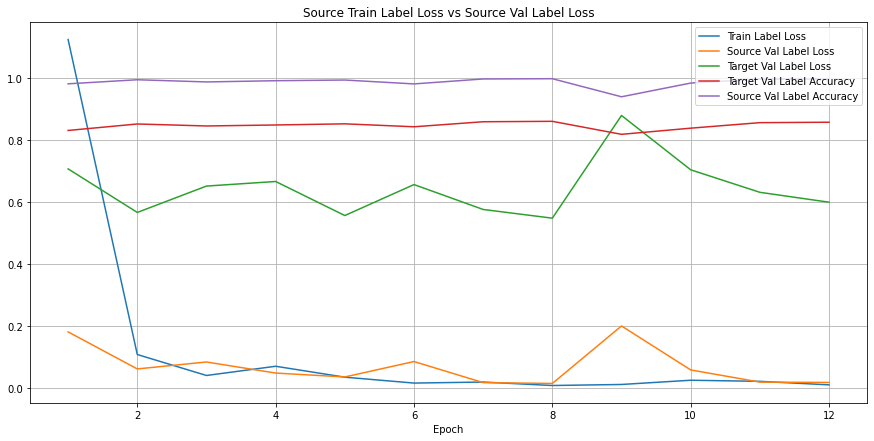

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

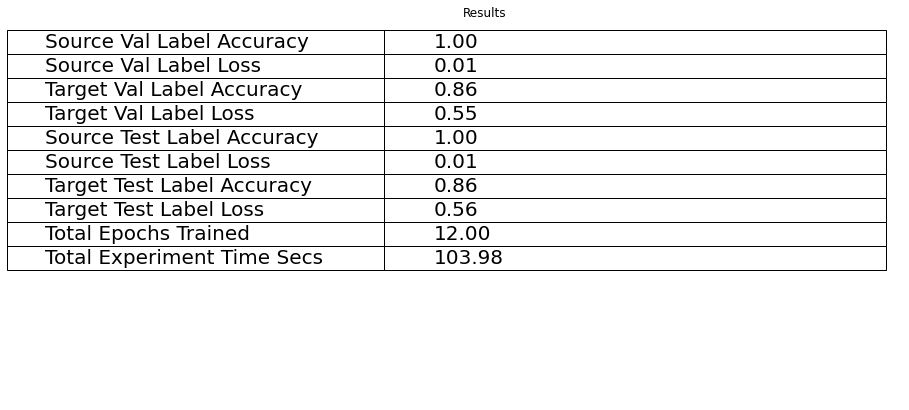

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

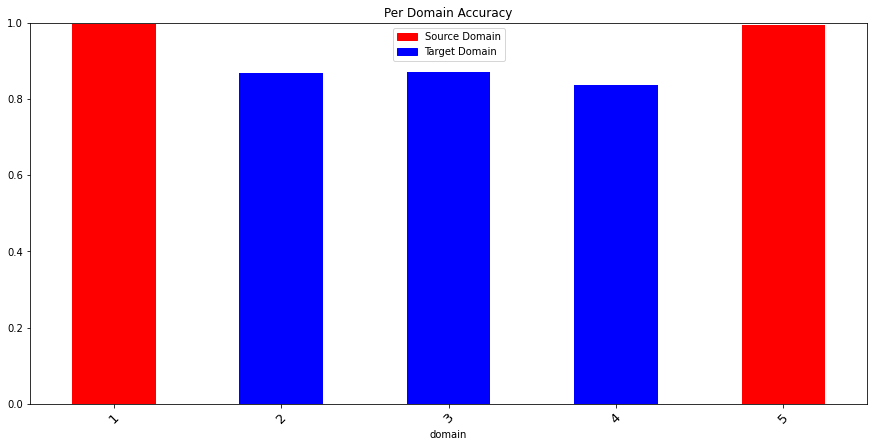

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.997319719208679 Target Test Label Accuracy: 0.8572715398819979
Source Val Label Accuracy: 0.9972274163389 Target Val Label Accuracy: 0.8597722095671981


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_1:cores", "parameters": {"experiment_name": "cnn_1:cores", "device": "cuda", "lr": 0.0001, "labels": ["1-10.", "1-11.", "1-15.", "1-16.", "1-17.", "1-18.", "1-19.", "10-4.", "10-7.", "11-1.", "11-14.", "11-17.", "11-20.", "11-7.", "13-20.", "13-8.", "14-10.", "14-11.", "14-14.", "14-7.", "15-1.", "15-20.", "16-1.", "16-16.", "17-10.", "17-11.", "17-2.", "19-1.", "19-16.", "19-19.", "19-20.", "19-3.", "2-10.", "2-11.", "2-17.", "2-18.", "2-20.", "2-3.", "2-4.", "2-5.", "2-6.", "2-7.", "2-8.", "3-13.", "3-18.", "3-3.", "4-1.", "4-10.", "4-11.", "4-19.", "5-5.", "6-15.", "7-10.", "7-14.", "8-18.", "8-20.", "8-3.", "8-8."], "batch_size": 128, "domains_source": [1, 5], "domains_target": [2, 3, 4], "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"